In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.integrate import trapz

pd.set_option("display.max_columns", None)  # Adjust the number as needed
data = pd.read_csv('alldata20231206.csv', header=None)
h2o_in_d2o = pd.read_csv('Baseline10p2H2OinD2O.csv')

In [2]:
#Spectrum Range (Raw)
initial_wl = 175
final_wl = 2500
range_wl = final_wl-initial_wl

#Visualization Range
minimum = 200
maximum = 2500

#Range for wavelenght correction
max_wl = 1800
min_wl = 300
sensitivity = 0.1

#Metallic peak for normalization
peakmin = 600
peakmax = 800

#water for rescale and substract H2O in D2O spectrum
peakminh2o = 2400
peakmaxh2o = 2500
sensitivityh2o = 0.01 #Increase rescaling factor
tolerance = 0.015  #Closest to Zero


#Baseline Correction
h2o_in_d2o['Wavelength (nm)'] = h2o_in_d2o['Wavelength (nm)'].astype(int)
h2o_in_d2o['Abs'] = h2o_in_d2o['Abs'].astype(float)
h2o_in_d2o = h2o_in_d2o.sort_values(by='Wavelength (nm)')
h2o_in_d2o =  h2o_in_d2o[(h2o_in_d2o['Wavelength (nm)'] < maximum) & (h2o_in_d2o['Wavelength (nm)'] > minimum)]


def prepare(df):
    df.columns = df.iloc[1]
    df = df.iloc[2:range_wl + 3]
    df['Wavelength (nm)'] = df['Wavelength (nm)'].astype(int)
    df['Abs'] = df['Abs'].astype(float)
    df = df.sort_values(by='Wavelength (nm)')
    df = df[(df['Wavelength (nm)'] < maximum) & (df['Wavelength (nm)'] > minimum)]
    return df

def H2OD2O_substraction(df):
    A = 0
    while ((df['Abs'][df['Wavelength (nm)'].between(peakminh2o, peakmaxh2o)] - A*h2o_in_d2o['Abs'][h2o_in_d2o['Wavelength (nm)'].between(peakminh2o, peakmaxh2o)]).max()-(df['Abs'][df['Wavelength (nm)'].between(peakminh2o, peakmaxh2o)] - A*h2o_in_d2o['Abs'][h2o_in_d2o['Wavelength (nm)'].between(peakminh2o, peakmaxh2o)]).min()> tolerance):
        A += sensitivityh2o

    df['Abs'] = df['Abs'] - A*h2o_in_d2o['Abs']
    return df, A

def wavelength_correction(df):
    A = 0
    wavelenghtrange = df['Wavelength (nm)'].between(min_wl, max_wl)
    while ((df['Abs'][wavelenghtrange] - A/df['Wavelength (nm)'][wavelenghtrange])> 0.0).all():
        A += sensitivity
        
    df['Abs'] = df['Abs'] - A/df['Wavelength (nm)']
    return df, A

def peak_normalization(df):
    peak_value = df[(df['Wavelength (nm)'].between(peakmin, peakmax))]['Abs'].max()
    df['Abs'] = df['Abs'] / peak_value
    return df

def find_max_peak_in_ranges(df, wavelength_ranges):
    peak_positions = []
    peak_intensities = []

    for wavelength_range in wavelength_ranges:
        min_wl, max_wl = wavelength_range

        # Filter data within the specified wavelength range
        subset_df = df[(df['Wavelength (nm)'] >= min_wl) & (df['Wavelength (nm)'] <= max_wl)]

        # Find the index of the maximum value in the 'Abs' column within the subset
        max_index = subset_df['Abs'].idxmax()

        # Get the corresponding position and intensity
        peak_positions.append(df.loc[max_index, 'Wavelength (nm)'])
        peak_intensities.append(df.loc[max_index, 'Abs'])

    # Combine positions and intensities into pairs
    result = list(zip(peak_positions, peak_intensities))

    return result


In [3]:

df_baseline = prepare(data[[0,1]])
df_SSF5     = prepare(data[[20,21]])
df_SSF4second = prepare(data[[18,19]])
df_SSF1B    = prepare(data[[2,3]])
df_SSF2     = prepare(data[[8,9]])
df_SSF2B    = prepare(data[[6,7]])
df_SSF3     = prepare(data[[10,11]])
df_SSF33    = prepare(data[[4,5]])
df_SSF3B    = prepare(data[[12,13]])
df_SSF6     = prepare(data[[14,15]])


Samples = {
    'SFF5 - Reference Tubes':                          df_SSF5, 
    'SFF4 2 - Reference Tubes Methanol':               df_SSF4second,
    'SFF1 B - TEMED Short Rinsing':                    df_SSF1B,
    'SFF2 - Trichloroethylene':                        df_SSF2,
    'SFF2 B - Trichloroethylene (Short Rinsing)':      df_SSF2B,
    'SFF3 - Tetrachloroethylene':                      df_SSF3,
    'SFF3 3 - Tetrachloroethylene (Reflux Filling)':   df_SSF33,
    'SFF3 B - Tetrachloroethylene (Short Rinsing)':    df_SSF3B,
    'SFF6 - TTF (Vapour Phase Filling)':               df_SSF6,
}


Samples = {
    'Reference Tubes (Water)':                              df_SSF5, 
    'Reference Tubes (Methanol)':                           df_SSF4second,
    'TEMED@SWCNT (Solvent Immersion + Short Rinsing)':      df_SSF1B,
    'TCE@SWCNT (Solvent Immersion)':                        df_SSF2,
    'TCE@SWCNT (Solvent Immersion + Short Rinsing)':        df_SSF2B,
    'PCE@SWCNT (Solvent Immersion)':                        df_SSF3,
    'PCE@SWCNT (Reflux)':                                   df_SSF33,
    'PCE@SWCNT (Solvent Immersion + Short Rinsing)':        df_SSF3B,
    'TTF@SWCNT (Vapour Phase)':                             df_SSF6,
}

#result = find_max_peak_in_ranges(Samples_PeakNorm['SFF1 B - TEMED Short Rinsing'], [(800, 1200), (1550, 1950)])

C:\Users\Cristian Borja\AppData\Local\Temp\ipykernel_3888\309255011.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Wavelength (nm)'] = df['Wavelength (nm)'].astype(int)
C:\Users\Cristian Borja\AppData\Local\Temp\ipykernel_3888\309255011.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abs'] = df['Abs'].astype(float)
C:\Users\Cristian Borja\AppData\Local\Temp\ipykernel_3888\309255011.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [4]:

def Check(sample_list, sample_type,Title):
        
    PlotSamples = {key: value for key, value in sample_type.items() if key in sample_list}

    for label, sample in PlotSamples.items():
        plt.figure(figsize=(10, 3))
        plt.axhline(0, color='black', linestyle='--', alpha=0.5)

        plt.plot(Samples[label]['Wavelength (nm)'], Samples[label]['Abs'], label='RAW: '+label)
        plt.plot(PlotSamples[label]['Wavelength (nm)'], PlotSamples[label]['Abs'], label='Sample: '+label)
        plt.plot(h2o_in_d2o['Wavelength (nm)'], h2o_in_d2o['Abs']*SValues[label], label='h2o_in_d2o', color='black')
        plt.plot(h2o_in_d2o['Wavelength (nm)'], WLCValues[label]/h2o_in_d2o['Wavelength (nm)'], label='background', color='darkred')

        #PLOT SETTINGS
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Absorption')
        #plt.ylim(-0.5, 2)
        #plt.xlim(1350, 2100)
        #plt.yscale('log')
        plt.title(f'Absorption Spectrum {Title} - Normalization peak used: Between {peakmin} nm and {peakmax} nm')
        plt.legend(loc='best')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add grid lines
        plt.minorticks_on()
 

def DataCorrection():
    #H2O in D2O Substraction
    Samples_Subs = copy.deepcopy(Samples)
    SValues = copy.deepcopy(Samples)
    for label, dframe in Samples_Subs.items():
        Samples_Subs[label], SValues[label] = H2OD2O_substraction(dframe)
        print(f'H2O in D2O substracted from {label}')

    #Background Substraction
    Samples_WLCorr = copy.deepcopy(Samples_Subs)
    WLCValues = copy.deepcopy(Samples_Subs)
    for label, dframe in Samples_WLCorr.items():
        Samples_WLCorr[label], WLCValues[label] = wavelength_correction(dframe)
        print(f'Background substracted from {label}')


    #Metallic Peak Normalization
    Samples_PeakNorm = copy.deepcopy(Samples_WLCorr)
    for label, dframe in Samples_PeakNorm.items():
        Samples_PeakNorm[label] = peak_normalization(dframe)
        print(f'Peak normalization for {label}')
    
    return Samples_Subs, Samples_WLCorr, Samples_PeakNorm, SValues, WLCValues



Samples_Subs, Samples_WLCorr, Samples_PeakNorm, SValues, WLCValues = DataCorrection()

H2O in D2O substracted from Reference Tubes (Water)
H2O in D2O substracted from Reference Tubes (Methanol)


H2O in D2O substracted from TEMED@SWCNT (Solvent Immersion + Short Rinsing)
H2O in D2O substracted from TCE@SWCNT (Solvent Immersion)
H2O in D2O substracted from TCE@SWCNT (Solvent Immersion + Short Rinsing)
H2O in D2O substracted from PCE@SWCNT (Solvent Immersion)
H2O in D2O substracted from PCE@SWCNT (Reflux)
H2O in D2O substracted from PCE@SWCNT (Solvent Immersion + Short Rinsing)
H2O in D2O substracted from TTF@SWCNT (Vapour Phase)
Background substracted from Reference Tubes (Water)
Background substracted from Reference Tubes (Methanol)
Background substracted from TEMED@SWCNT (Solvent Immersion + Short Rinsing)


In [ ]:
sample_list =   [
                'SFF1 B - TEMED Short Rinsing',
                'SFF2 - Trichloroethylene',
                'SFF2 B - Trichloroethylene (Short Rinsing)',
                'SFF3 - Tetrachloroethylene',
                'SFF3 3 - Tetrachloroethylene (Reflux Filling)',
                'SFF3 B - Tetrachloroethylene (Short Rinsing)',
                'SFF6 - TTF (Vapour Phase Filling)'
                ]

sample_list = {
    'Reference SWCNT (Water)', 
    'Reference SWCNT (Methanol)',
    'TEMED@SWCNT (Solvent Immersion + Short Rinsing)',
    'TCE@SWCNT (Solvent Immersion)',
    'TCE@SWCNT (Solvent Immersion + Short Rinsing)',
    'PCE@SWCNT (Solvent Immersion)',
    'PCE@SWCNT (Reflux)',
    'PCE@SWCNT (Solvent Immersion + Short Rinsing)',
    'TTF@SWCNT (Vapour Phase)'
}

#Check to compare with raw
#Check(sample_list, Samples_Subs, 'Samples without H2O in D2O')
#Plot(sample_list, Samples, 'Raw Samples')
#Plot(sample_list, Samples_Subs, 'Samples without H2O in D2O')
#Plot(sample_list, Samples_WLCorr, 'Samples without Background')
#Plot(sample_list, Samples_PeakNorm, 'Samples Normalized')

#Plot(sample_list, Samples_PeakNorm, 'Samples Normalized')

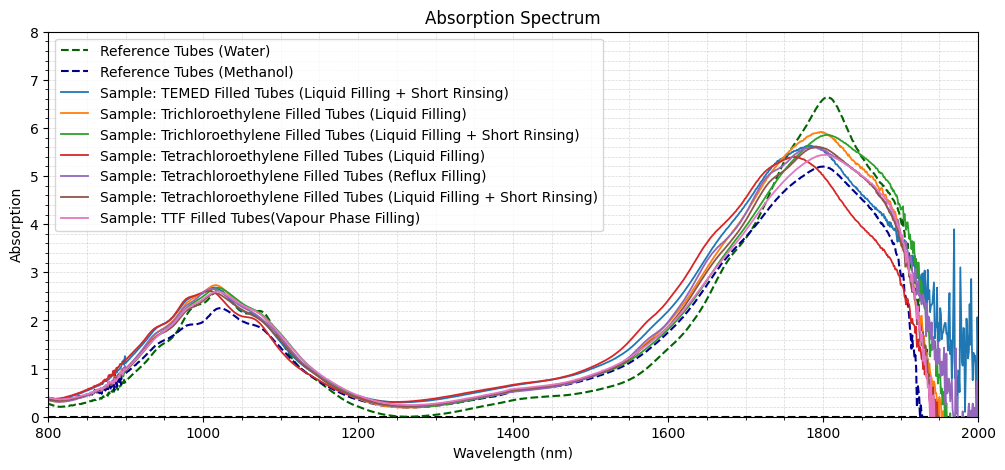

In [ ]:
sample_list =   [
                'SFF1 B - TEMED Short Rinsing',
                'SFF2 - Trichloroethylene',
                'SFF2 B - Trichloroethylene (Short Rinsing)',
                'SFF3 - Tetrachloroethylene',
                'SFF3 3 - Tetrachloroethylene (Reflux Filling)',
                'SFF3 B - Tetrachloroethylene (Short Rinsing)',
                'SFF6 - TTF (Vapour Phase Filling)'
                ]

sample_list = {
#    'Reference SWCNT (Water)', 
#    'Reference SWCNT (Methanol)',
    'TEMED@SWCNT (Solvent Immersion + Short Rinsing)',
    'TCE@SWCNT (Solvent Immersion)',
    'TCE@SWCNT (Solvent Immersion + Short Rinsing)',
    'PCE@SWCNT (Solvent Immersion)',
    'PCE@SWCNT (Reflux)',
    'PCE@SWCNT (Solvent Immersion + Short Rinsing)',
    'TTF@SWCNT (Vapour Phase)'
}
#Check to compare with raw
#Check(sample_list, Samples_Subs, 'Samples without H2O in D2O')
#Plot(sample_list, Samples, 'Raw Samples')
#Plot(sample_list, Samples_Subs, 'Samples without H2O in D2O')
#Plot(sample_list, Samples_WLCorr, 'Samples without Background')


def Plot(sample_list, sample_type,Title):
        
    #PARAMETERS
    plt.figure(figsize=(12, 5))

    PlotSamples = {key: value for key, value in sample_type.items() if key in sample_list}
    
    #SAMPLE PLOTTING

    for label, sample in PlotSamples.items():
        plt.plot(PlotSamples[label]['Wavelength (nm)'], PlotSamples[label]['Abs'], label='Sample: '+label, linewidth=1.3)
        #plt.plot(h2o_in_d2o['Wavelength (nm)'], h2o_in_d2o['Abs']*SValues[label], label='h2o_in_d2o', color='black')

    plt.axhline(0, color='black', linestyle='--')
    plt.plot(sample_type['Reference Tubes (Water)']['Wavelength (nm)'], sample_type['Reference Tubes (Water)']['Abs'], label='Reference Tubes (Water)', color='darkgreen',linestyle='--',linewidth=1.5)
    plt.plot(sample_type['Reference Tubes (Methanol)']['Wavelength (nm)'], sample_type['Reference Tubes (Methanol)']['Abs'], label='Reference Tubes (Methanol)', color='darkblue',linestyle='--',linewidth=1.5)

    #PLOT SETTINGS
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorption (a.u.)')
    
    #plt.ylim(0,0.7)
    plt.ylim(0,8)
    #plt.ylim(-0.1,7)

    #plt.xlim(1600, 1900)
    
    plt.xlim(800, 2000)
    
    #plt.yscale('log')
    #plt.title(f'Absorption Spectrum {Title} - Normalization peak used: Between {peakmin} nm and {peakmax} nm')
    plt.title(f'Absorption Spectra')
    plt.legend(loc='best')

    #plt.axvspan(800, 1200, color='gray', alpha=0.3)
    #plt.axvspan(1550, 1950, color='gray', alpha=0.3)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add grid lines
    plt.minorticks_on()
    plt.savefig('Absorption.png',dpi=500)

    
Plot(sample_list, Samples_PeakNorm, 'Samples Normalized')

In [ ]:
from scipy.integrate import trapz

def integrate_area_in_ranges(df, wavelength_ranges):
    area_list = []

    for wavelength_range in wavelength_ranges:
        min_wl, max_wl = wavelength_range

        # Filter data within the specified wavelength range
        subset_df = df[(df['Wavelength (nm)'] >= min_wl) & (df['Wavelength (nm)'] <= max_wl)]

        # Ensure the data is sorted by wavelength
        subset_df = subset_df.sort_values(by='Wavelength (nm)')

        # Integrate the area using the trapezoidal rule
        area = trapz(subset_df['Abs'], subset_df['Wavelength (nm)'])

        area_list.append(area)

    return area_list



# Example usage:
# Assuming 'your_dataframe' is the DataFrame containing your data
#wavelength_ranges = [(800, 1200), (1550, 1950)]
#area_list = integrate_area_in_ranges(your_dataframe, wavelength_ranges)





PeaksInfo = copy.deepcopy(Samples_PeakNorm)

for label in Samples_PeakNorm.keys():
    PeaksInfo[label] = find_max_peak_in_ranges(Samples_PeakNorm[label], [(800, 1200), (1550, 1950)])



table = pd.DataFrame(PeaksInfo).T.reset_index().rename(columns={'index': 'Sample'})

table[['Wavelength S22 (nm)', 'Intensity S22']] = table[0].apply(pd.Series)
table[['Wavelength S11 (nm)', 'Intensity S11']] = table[1].apply(pd.Series)
table[['S11 Shift H2O Reference (nm)']] = table['Wavelength S11 (nm)'].apply(lambda x: x-table['Wavelength S11 (nm)'][table['Sample']=='SFF5 - Reference Tubes'])
table[['S11 Shift Methanol Reference (nm)']] = table['Wavelength S11 (nm)'].apply(lambda x: x-table['Wavelength S11 (nm)'][table['Sample']=='SFF4 2 - Reference Tubes Methanol'])
table[['S22 Shift H2O Reference (nm)']] = table['Wavelength S22 (nm)'].apply(lambda x: x-table['Wavelength S22 (nm)'][table['Sample']=='SFF5 - Reference Tubes'])
table[['S22 Shift Methanol Reference (nm)']] = table['Wavelength S22 (nm)'].apply(lambda x: x-table['Wavelength S22 (nm)'][table['Sample']=='SFF4 2 - Reference Tubes Methanol'])
table['Ratio'] = table['Intensity S22']/table['Intensity S11']


table = table.drop(columns=[0,1])

table.to_csv('Peaks.csv', index=None)

table.sort_values(by='S11 Shift Methanol Reference (nm)', ascending=True)


ValueError: Columns must be same length as key